# Optimizing dynamical blockade via a particle-swarm-optimization algorithm

Based on paper: DOI: https://doi.org/10.1103/PhysRevA.110.023718

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val_dm
from torchqc.operators import DynamicOperator
from torchqc.common_matrices import annihilation, creation
from torchqc.dynamics import lindblad_equation
from torchqc.correlation import correlation_fn_3op_1time

import torch

* Initial state is a coherent state

$\ket{\psi} = \ket{b}$

In [2]:
N = 50 # number of fock states
b1 = 0.1
coherent_state = QuantumState.coherent(N, b1)

initial_state = coherent_state

* Simulate dynamics

In [3]:
Dt = 0.01

γ = 1
U = 0.05 * γ  # nonlinear coupling
Δ = 0.5 * γ
A = 5.27
ep = 0.1 * γ
m = 10
T_period = 5

time = np.arange(0, 40, Dt)

* Hamiltonian of a bosonic Josephson junctions with two quantuzed modes (Bos-Hubband approximation)

$H = \Delta a^\dagger a + U a^\dagger a^\dagger a a + \epsilon(t)(a^\dagger + a)$

In [4]:
a_dagger = creation(N)
a = annihilation(N)

N_op = a_dagger * a

In [5]:
def et(t):
    sum_term = 0

    for i in range(m):
        sum_term += torch.exp(-A**2 * γ ** 2 * (t - i * T_period) ** 2)

    e_t = (ep * A / np.sqrt(np.pi)) * sum_term

    return e_t

def Ht(t, params=[]):
    H1 = Δ * N_op + U * a_dagger * a_dagger * a * a 

    sum_term = 0

    for i in range(m):
        sum_term += torch.exp(-A**2 * γ ** 2 * (t - i * T_period) ** 2)

    e_t = (ep * A / np.sqrt(np.pi)) * sum_term
        

    H2 = e_t * (a_dagger + a)

    H = H1 + H2

    return H.matrix

hamiltonian = DynamicOperator(N, Ht, time=time)

* Simulate dynamics with von-Neumann equations

In [6]:
rho = get_density_matrix(initial_state)

jump_ops = [a]
rates = [γ]

_, states = lindblad_equation(rho, hamiltonian, time, Dt, jump_ops, rates)

In [7]:
expectation_values_N = expect_val_dm(states, N_op)

In [8]:
""" G2 = torch.tensor([torch.real(torch.trace((a_dagger * a_dagger * a * a * state).matrix)) for state in states])
g2 = G2 / (expectation_values_N ** 2) """

G2 = np.array([correlation_fn_3op_1time(None, rho, None, Dt, a_dagger, a_dagger * a, a, None, None) for rho in states])
g2 = G2 / (expectation_values_N ** 2)

In [9]:
time_tensor = torch.from_numpy(time).reshape(len(time), 1)
e_t = [et(t) for t in time_tensor]

Text(0.5, -0.5, '(c)')

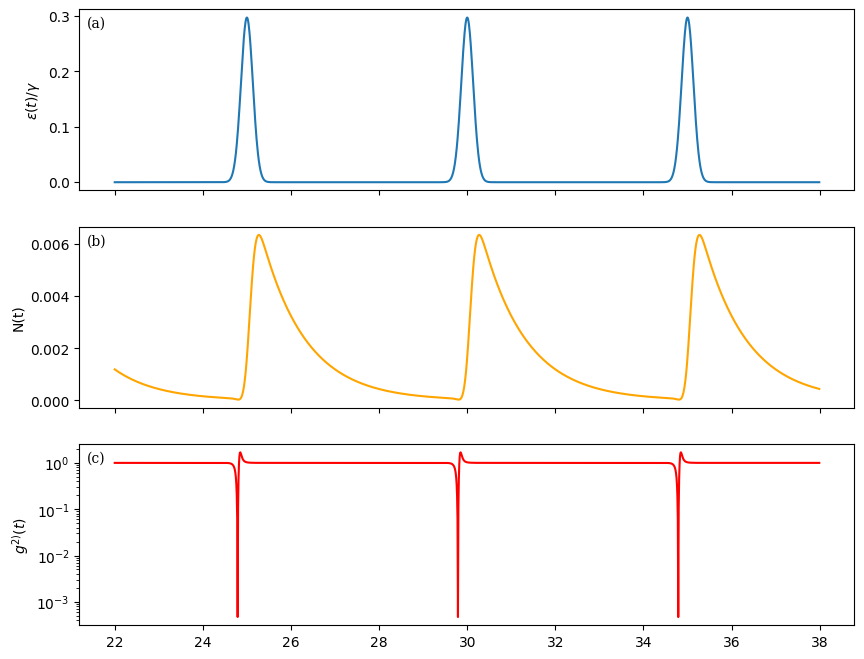

In [10]:
fig, axs = plt.subplots(3, 1, sharex='col')

fig.set_figheight(8)
fig.set_figwidth(10)

pulse_fig = axs[0]
pop_fig = axs[1]
corr_fig = axs[2]

pulse_fig.plot(time[2200:3800], e_t[2200:3800], label=r"$\epsilon(t)$")
pulse_fig.set_ylabel(r"$\epsilon(t) / \gamma$")

pulse_fig.annotate(
        "(a)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

pop_fig.plot(time[2200:3800], expectation_values_N[2200:3800], color="orange", label=r"N(t)")
pop_fig.set_ylabel(r"N(t)")

pop_fig.annotate(
        "(b)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)

corr_fig.plot(time[2200:3800], g2[2200:3800], color="red", label=r"$g^{(2)}$")
corr_fig.set_ylabel(r"$g^{2)}(t)$")
corr_fig.set_yscale("log")
corr_fig.annotate(
        "(c)",
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.5, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', fontfamily='serif',)